In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src')

In [ ]:
from ponysynth.models.label_embeddings import *

# if we have excess gpu memory and compute, virtualize the gpu to increase the batch size
# if we have excess gpu compute, run multiple steps per batch

# treat gradient descent as a beam search
# if we have excess gpu memory, increase the beam size
# if we have excess gpu compute, increase the beam depth

archive_fn = '/home/celestia/data/audio-tfrecord/*'

# strategy = tf.distribute.OneDeviceStrategy(device='/gpu:0')
#strategy = tf.distribute.MirroredStrategy()
gpus = tf.config.experimental.list_logical_devices('GPU')
strategy = snt.distribute.Replicator(
    [f"/device:GPU:{i}" for i in range(len(gpus))],
    tf.distribute.ReductionToOneDevice("GPU:0")
)
print(f'using {len(gpus)} gpus')

replica_batch_size = 64
global_batch_size = replica_batch_size * len(gpus)


dataset = input_db(archive_fn, global_batch_size)
dataset = strategy.experimental_distribute_dataset(dataset)


with strategy.scope():
    opt = snt.optimizers.Adam(learning_rate=0.0004)
    model = VAEModel(SimpleVAE(30))
    
    def train_step(ids, weights):
        features = tf.sparse.to_dense(weights)
        features.set_shape((replica_batch_size, index_end - index_start))
        loss, grads, params = model.gradients(features)
        opt.apply(grads, params)
        return loss
        
    @tf.function
    def distributed_train_step(ids, weights):    
        losses = strategy.experimental_run_v2(train_step, args=(ids, weights))
        return strategy.reduce(tf.distribute.ReduceOp.SUM, losses, axis=None) / global_batch_size
        
    for ids, weights in dataset:
        loss = distributed_train_step(ids, weights)
        print(loss)

# todo: test this with tpus
# todo: add loss mask for unknown values
# todo: train with bert-like mask
# todo: figure out what structure to use... convolution?
# todo: figure out how to generate embeddings
# todo: create a encoding -> 2d differential net for speech
# todo: write custom optimizer for metalearning
# THEN improve with xlnet, al-bert, etc



Burnt-Oak-outtakes:s7e13-2091.709668-2093.725019
0.101479165
0.18 1.7097917
8640
0
bounds: [   0    1    2 ... 8637 8638 8639]
samples: (8640,)
composed: (8640,)
96737
82070
bounds: [82070 82071 82072 ... 96734 96735 96736]
samples: (14667,)
composed: (14667,)
21120
0
bounds: [    0     1     2 ... 21117 21118 21119]
samples: (21120,)
composed: (21120,)


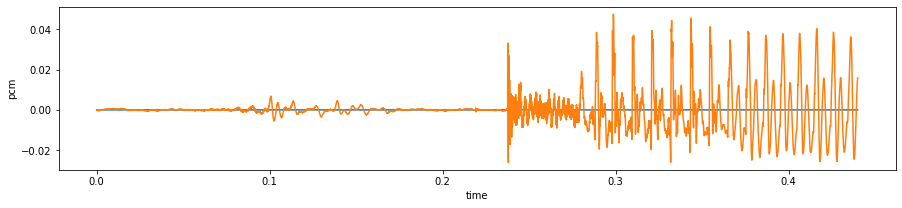

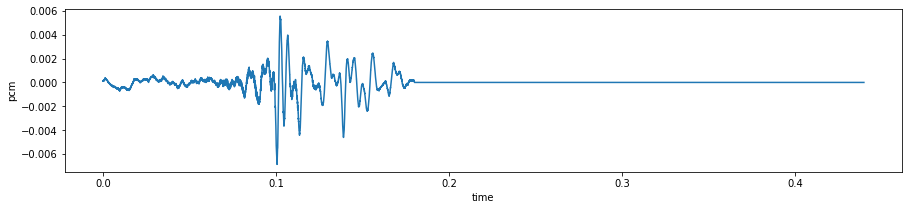

In [2]:
from ponysynth.corpus import *
from ponysynth.clipbot import ClipBot
from datapipes.audiorecord_out import *
from IPython import display as ipd
import numpy as np
import scipy

archive = ClipperArchive('/home/celestia/data/clipper-preproc/audio-tar/Burnt-Oak.tar')
extra = InfoArchive('/home/celestia/data/clipper-preproc/audio-info/Burnt-Oak.txz')

def find_cutoff_times(label, info):
    utt_start = float(label['words'][0]['interval'][0])
    utt_end = float(label['words'][-1]['interval'][-1])
    gcis = [float(x) for x in info['gci.sec']]
    voice_start = gcis[0]
    voice_end = gcis[-1]
    
    intensities = [x for x in info['intensity']]
    th = threshold([float(x['volume.db']) for x in intensities])
    
    for x in intensities:
        if float(x['volume.db']) >= th:
            sound_start = float(x['time.sec'])
            break
    
    for x in intensities[::-1]:
        if float(x['volume.db']) >= th:
            sound_end = float(x['time.sec'])
            break
    
    print(voice_start)
    return max(utt_start, voice_start, sound_start), min(utt_end, voice_end, sound_end)

def fade(indexes):
    return indexes * 0

def threshold(intensities):
    intensities = numpy.array(intensities)
    
    mean = np.mean(intensities)
    median = np.median(intensities)
    reference = None

    if median > mean:
        reference = median
    else:
        reference = np.median(intensities[intensities > mean])

    return reference - 13




def apply_faded_trim(key):
    audio = archive.read_audio(key)
    samples, rate = librosa.core.load(audio, sr=None)
    label = archive.read_label(key)
    info = extra.read_info(key)
    
    clipbot = ClipBot(samples, rate)
    start_time, end_time = find_cutoff_times(label, info)
    print(start_time, end_time)
    
    start, mid, end = clipbot.split(start_time, end_time)
    start.mod.crossfade(pre=fade)
    end.mod.crossfade(post=fade)
    
    return clipbot.get_samples(), rate

import matplotlib.pyplot as plt

for key in archive.sample(k=1):
# for key in ('Burnt-Oak-outtakes:s7e13-2266.283789-2268.209568',):
    print(key)
    clean_samples, rate = apply_faded_trim(key)    
    unclean_file = archive.read_audio(key)
    unclean_samples, _ = librosa.core.load(unclean_file, sr=None)
    
    trim_diff = clean_samples - unclean_samples
    label = archive.read_label(key)
    
    trimbot = ClipBot(clean_samples, rate).first_word(label)
    diffbot = ClipBot(trim_diff, rate).first_word(label)
    clipbot = ClipBot(unclean_samples, rate).first_word(label)
    
    envelope = numpy.zeros(shape=trimbot.get_samples().shape) + 1
    envbot = ClipBot(envelope, rate)
    envbot.mod.crossfade(pre=fade)
    
    trimbot.draw.audio()
    
    clipbot.draw.figure()
    envbot.draw.samples()
    clipbot.draw.samples()
    
    clipbot.draw.show()

    
    diffbot.draw.figure()
    diffbot.draw.samples()
    diffbot.draw.show()


    
# TODO: move ClipDrawBot to DrawBot

In [ ]:
# edge cases:
# Burnt-Oak-outtakes:s7e13-2111.012246-2112.833525
# Burnt-Oak-outtakes:s7e13-2000.182908-2003.228327


In [16]:
from ponysynth.widgets.sound import SoundSelectionWidget
from ponysynth import widgets
from IPython import display as ipd

widgets.load_js('SoundSelectionWidget.js')

samples1 = clipbot.get_samples().tolist()
widget1 = SoundSelectionWidget(
    data={'samples': samples1, 'rate': rate},
    transition_time=350,
    size={'width': 920, 'height': 240})
ipd.display(widget1)

samples2 = diffbot.get_samples().tolist()
widget2 = SoundSelectionWidget(
    data={'samples': samples2, 'rate': rate})
ipd.display(widget2)


<IPython.core.display.Javascript object>

SoundSelectionWidget(data={'samples': [-0.0001220703125, -9.1552734375e-05, -9.1552734375e-05, -0.000152587890…

SoundSelectionWidget(data={'samples': [0.0001220703125, 9.1552734375e-05, 9.1552734375e-05, 0.000152587890625,…

In [15]:
widget1.marks = [0.10, 0.4];
widget2.marks = [0.08, 0.3]

print(widget1.selection)

widget1.transition_time = 500
widget1.data = {'samples':samples1, 'rate':rate}

0.15806494728915663


In [4]:
%load_ext py_d3

In [7]:
%%d3

<g></g>

<script>
console.log(d3);
</script>

In [ ]:
%%javascript

class XSvgDisplay {
    svg;
    width;
    height;
    
    constructor({svg, width, height}) {
        this.svg = svg;
        this.width = width;
        this.height = height;
    }
}

let x = new XSvgDisplay({svg: 1, ...{width: 2, height: 3}})
console.log(x)
